<a href="https://colab.research.google.com/github/suryogumilar/Tensorflow_timeseries/blob/main/C4_W2_Lab_2_single_layer_NN_2_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Layer Neural Network with Time Series Data but with normalization

and other tweaks

references:
 - https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb

see also:

 - https://github.com/suryogumilar/Tensorflow_timeseries/blob/main/C4_W2_Lab_2_single_layer_NN.ipynb

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
# for timezone()
import pytz
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from IPython.display import clear_output

## functions

we'll define some utility functions that we'll repeatedly use

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def plot_series_plotly(time, series, series_name=None, 
                       figure_title='', showlegend=False, 
                       start=0, end=None):
    """
    Visualizes time series data but using plotly for interactive graph

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      series_name (array of string) - contains correlative name of each series
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    fig = go.Figure()
    # Setup dimensions of the graph figure
    
    if type(series) is tuple:
      ii = 0
      for series_num in series:
        # Plot the time series data
        fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series_num[start:end], mode='lines',
                                 name=series_name[ii]))  
        ii = ii+1
    else:
      # Plot the time series data
      fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series[start:end], mode='lines'))

    fig.update_layout(title=figure_title, xaxis_title="Time", yaxis_title="Value",
                      autosize=False,
                      width=600,
                      height=600,
                      margin=dict(
                        l=50,
                        r=50,
                        b=100,
                        t=100,
                        pad=4
                        ), paper_bgcolor="LightSteelBlue"
                        , showlegend=showlegend
                      )
    fig.show()



def getStockData(history_span:int, the_ticker:str):
  """
  Getting stock data from Yahoo Finance API

  Args:
    history_span (int) how much backdate data to be collected
    the_ticker (string) ticker name on yahoo finance API
  Returns:
    Pandas dataframe (pd.DataFrame) containing stock data    
  """
  THE_URL = ('https://query1.finance.yahoo.com/v7/finance/'+
           'download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true')
  tdy = datetime.datetime.now(tz=pytz.timezone('Asia/Jakarta'))

  p2 = math.ceil(tdy.timestamp())
  p1 = math.floor((tdy - relativedelta(years=history_span)).timestamp())
  yf_url = THE_URL.format(ticker=the_ticker,period1=p1, period2=p2)
  df = pd.read_csv(yf_url)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  return df
     

In [ ]:
stock_name = str(input("Stock tick:"))
hist_data = int(input("historical data (year):"))
clear_output(wait=True)

In [4]:
df = getStockData(hist_data, stock_name)

In [5]:
plot_series_plotly(df['Date'], (df['Open'], df['Close']),
                   series_name=['Open', 'Close'],
                   figure_title='price', showlegend=True)

In [6]:

fig = go.Figure(data= [go.Candlestick(x=df['Date'],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close']
                             )])
fig.show()

## Split the Dataset
We split the dataset as training and test

Please do note in mind that when splitting the data into training and test set always take care on the distribution of data. Does it represent data on each month equally? Does the data have seasonal feature in it? Does it actually creates bias instead?

In [7]:
split_ratio = 0.8
rows_of_dataframe = df.shape[0]

training_ds_rows = round(rows_of_dataframe * split_ratio)
test_ds_rows = round(rows_of_dataframe * (1- split_ratio))

print(training_ds_rows)
print(test_ds_rows)

df_training = df[:training_ds_rows]
df_test = df[training_ds_rows:]

print(df.shape)
print(df_training.shape)
print(df_test.shape)

588
147
(735, 7)
(588, 7)
(147, 7)


In [8]:
plot_series_plotly(df_training['Date'], df_training['Close'],
                   figure_title='training dataset')

In [9]:
plot_series_plotly(df_test['Date'], df_test['Close'],
                   figure_title='test dataset')

## Prepare features and labels
prepare window data for time series forecasting

#### Parameters
we define parameters here

`window_size = 20` means we are going to predict future data using 20 previous data.

One thing to note here is the `window_size + 1` when we call `dataset.window()`. There is a `+ 1` to indicate that we're taking the next point as the label. For example, the first 20 points will be the feature so the 21st point will be the label.

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
     

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

### Normalize

we normalize the training data first. 

Normalizing a set of data transforms the set of data to be on a similar scale. For machine learning models, our goal is usually to recenter and rescale our data such that is between 0 and 1 or -1 and 1, depending on the data itself. One common way to accomplish this is to calculate the mean and the standard deviation on the set of data and transform each sample by subtracting the mean and dividing by the standard deviation, which is good if we assume that the data follows a normal distribution as this method helps us standardize the data and achieve a standard normal distribution.

Normalization can help training of our neural networks as the different features are on a similar scale, which helps to stabilize the gradient descent step, allowing us to use larger learning rates or help models converge faster for a given learning rate.

In [12]:
normalizer_univar = tf.keras.layers.Normalization(axis=None)

training_set = tf.convert_to_tensor(df_training['Close'])
normalizer_univar.adapt(training_set)

training_set_normalized = normalizer_univar(training_set)
print('training set range:')
print('min:',tf.reduce_min(training_set_normalized, axis=0).numpy())
print('max:', tf.reduce_max(training_set_normalized, axis=0).numpy())

test_set = tf.convert_to_tensor(df_test['Close'])
test_set_normalized = normalizer_univar(test_set)
print()
print('test set range:')
print('min:',tf.reduce_min(test_set_normalized, axis=0).numpy())
print('max:', tf.reduce_max(test_set_normalized, axis=0).numpy())


training set range:
min: -1.842931
max: 2.3457036

test set range:
min: 0.12819114
max: 2.3077974


In [13]:
plot_series_plotly(df_training['Date'], training_set_normalized,
                   figure_title='training dataset normalized')

In [14]:
plot_series_plotly(df_test['Date'], test_set_normalized,
                   figure_title='test dataset normalized')

generate windowed train dataset

In [15]:
# Generate the dataset windows
windowed_training_ds = windowed_dataset(training_set_normalized, window_size, 
                           batch_size, shuffle_buffer_size)

# Print properties of a single batch
for windows in windowed_training_ds.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')
     

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model



In [16]:
class TSSequentialModel(tf.keras.Model):
  def __init__(self, window_size, **kwargs):
    super(TSSequentialModel, self).__init__(**kwargs)
    self.dense_1 = tf.keras.layers.Dense(1, input_shape=[window_size])
    # Print the initial layer weights
    print("Layer weights: \n {} \n".format( self.dense_1.get_weights()))
    
  def call(self, x):
    x = self.dense_1(x)
    return x

In [17]:
model = TSSequentialModel(window_size=window_size)
model.build(input_shape = (1, window_size))
# Print the model summary
model.summary()

Layer weights: 
 [] 

Model: "ts_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Set the training parameters
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,
                                                momentum=0.9))

## Train the Model
Now you can proceed to train your model. You will feed in the prepared data windows and run the training for 100 epochs.

In [19]:
# Train the model
history = model.fit(windowed_training_ds, epochs=100, verbose=0)

## Plot the model Loss

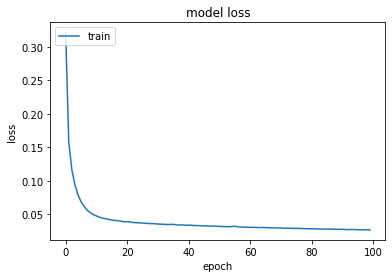

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
plot_series_plotly(np.arange(0,100), history.history['loss'], figure_title='Loss value' )

looks better

## Model Prediction

With the training finished, you can now measure the performance of your model. You can generate a model prediction by passing a batch of data windows. If you will be slicing a window from the original `series` array, you will need to add a batch dimension before passing it to the model. That can be done by indexing with the `np.newaxis constant` or using the `np.expand_dims()` method.

The slice index below is split_time - window_size: because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the forecast list corresponds to the prediction for time at index 20. You cannot make predictions at index 0 to 19 because those are smaller than the window size. Thus, when you slice with split_time - window_size:, you will be getting the points at the time indices that aligns with those in the validation set.

But we need to normaqlized the data first

In [22]:
# Initialize a list
forecast = []

dataset_to_forecast = df['Close'].iloc[training_ds_rows-window_size:]
print(dataset_to_forecast.shape)
ds_normalized = normalizer_univar(dataset_to_forecast)
print(ds_normalized.shape)


for time in range(ds_normalized.shape[0] - window_size):
  forecast.append(model.predict(
      np.expand_dims(ds_normalized[time:time + window_size], axis=0), verbose=0))
print(time,':',(time + window_size))  
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {test_set_normalized.shape}')

(167,)
(167,)
146 : 166
length of the forecast list: 147
shape of the validation set: (147,)


To visualize the results, you will need to convert the predictions to a form that the `plot_series()` utility function accepts. That involves converting the list to a numpy array and dropping the single dimensional axes

shape after converting to numpy array: (147, 1, 1)
shape after squeezing: (147,)


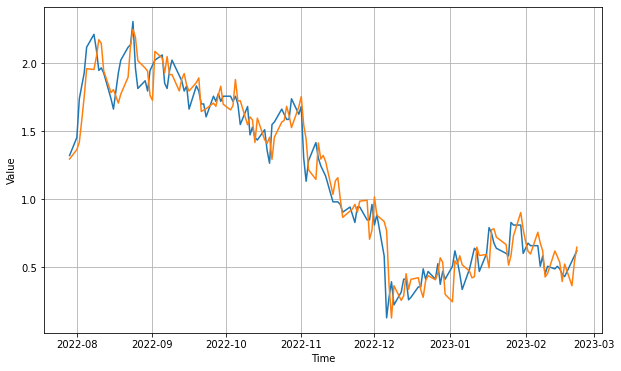

In [23]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set_normalized, results))

In [24]:
plot_series_plotly(df_test['Date'], (test_set_normalized, results),
                   series_name=['test_set','prediction'],
                   figure_title='dataset normalized',
                   showlegend=True)

## Count the metrics

In [25]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(test_set_normalized, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_set_normalized, results).numpy())

0.020626687
0.11223791


### if we do not normalize

In [26]:
# Initialize a list
forecast = []

dataset_to_forecast = df['Close'].iloc[training_ds_rows-window_size:]

for time in range(dataset_to_forecast.shape[0] - window_size):
  forecast.append(model.predict(
      np.expand_dims(dataset_to_forecast[time:time + window_size], axis=0), verbose=0))
  
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {test_set.shape}')


length of the forecast list: 147
shape of the validation set: (147,)


shape after converting to numpy array: (147, 1, 1)
shape after squeezing: (147,)


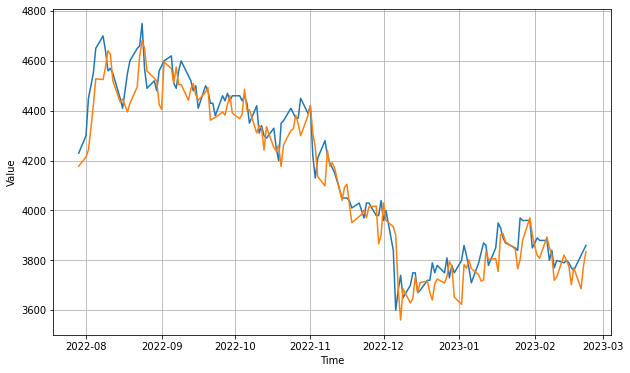

In [27]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set, results))

In [28]:
plot_series_plotly(df_test['Date'], (test_set, results),
                   series_name=['test_set','prediction'],
                   figure_title='dataset',
                   showlegend=True)

In [29]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(test_set, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_set, results).numpy())

6941.9033
64.0331


## tomorrow prediction

In [30]:
model.predict(np.expand_dims(test_set[-window_size:], axis=0)).squeeze()

1/1 [==============================] - 0s 50ms/step


array(3825.85, dtype=float32)